In [1]:
import awkward as ak
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from tqdm import tqdm
import xgboost
import catboost
import coffea
import hist
import vector
vector.register_awkward()

/afs/cern.ch/user/n/nmangane/.local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
#help(train_test_split)

In [3]:
from coffea import processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema

In [4]:
tttt = NanoEventsFactory.from_root(
    "/eos/home-n/nmangane/analysis/February10_Baseline_2018/Nano/ElMu/2018___tttt.root",
    schemaclass=BaseSchema, 
    entry_stop=None
).events()
#tttt = tttt[tttt.dsid1k < 50]
ttlight = NanoEventsFactory.from_root(
    "/eos/home-n/nmangane/analysis/February10_Baseline_2018/Nano/ElMu/2018___ttother_DL-GF_fr.root", 
    schemaclass=BaseSchema, 
    entry_stop=None
).events()
#ttlight = ttlight[ttlight.dsid1k < 50] #Need to recreate this dataset... le sigh
ttbb = NanoEventsFactory.from_root(
    "/eos/home-n/nmangane/analysis/February10_Baseline_2018/Nano/ElMu/2018___ttbb_DL-GF_fr.root", 
    schemaclass=BaseSchema, 
    entry_stop=None
).events()
#mumu_tttt = NanoEventsFactory.from_root(
#    "/eos/home-n/nmangane/analysis/February10_Baseline_2018/Nano/MuMu/2018___tttt.root", schemaclass=BaseSchema, entry_stop=10000
#).events()

In [5]:
events = tttt

In [6]:
len(tttt), len(ttlight), len(ttbb)

(208181, 744126, 24965)

In [ ]:
model_vLF = None
model_vHF = None
model_nested_layer1 = None
model_nested_layer2 = None

In [7]:
def get_features(events, 
                 remove_negative_weights=False, 
                 scale_systematic="nom", 
                 wgt_systematic="nom", 
                 e_filter=lambda e: e.dsid1k < 500,
                 models_features=None
                ):
    ret = dict()
    mus = ak.zip({"pt": events.FTAMuon_pt, 
                  "eta": events.FTAMuon_eta, 
                  "phi": events.FTAMuon_phi, 
                  "mass": events.FTAMuon_mass,
                  "loose": events.FTAMuon_looseId,
                  #"isolation": (events.FTAMuon_pfIsoId >= 4)
                 },
                 with_name="Momentum4D"
                )
    els = ak.zip({"pt": events.FTAElectron_pt, 
                  "eta": events.FTAElectron_eta, 
                  "phi": events.FTAElectron_phi, 
                  "mass": events.FTAElectron_mass,
                  "loose": (events.FTAElectron_cutBased >= 2),
                  #"isolation": (don't have it... le sigh)
                 },
                 with_name="Momentum4D"
                )
    jets = ak.zip({"pt": getattr(events, f"FTAJet__{scale_systematic}_pt"), 
                  "eta": getattr(events, f"FTAJet__{scale_systematic}_eta"), 
                  "phi": getattr(events, f"FTAJet__{scale_systematic}_phi"), 
                  "mass": getattr(events, f"FTAJet__{scale_systematic}_mass"),
                  "btag": getattr(events, f"FTAJet__{scale_systematic}_DeepJetB"),
                 },
                 with_name="Momentum4D"
                )

    selection = (
        (ak.num(getattr(events, f"FTAJet__{scale_systematic}_pt"), axis=1) >= 4) 
        & (ak.sum(getattr(events, f"FTAJet__{scale_systematic}_pt"), axis=1) >= 500)
        & (np.abs(getattr(events, f"FTAMuon_InvariantMass") - 91) > 15)
        & (
            (getattr(events, f"FTAMuon_InvariantMass") < 0)
            | (getattr(events, f"FTAMuon_InvariantMass") > 20)
        )
        & (
            (ak.num(els, axis=1) + ak.num(mus, axis=1)) == 2
        )
        & (getattr(events, f"nMediumDeepJetB__{scale_systematic}") > 1)
    )
    if remove_negative_weights:
        selection = selection & (getattr(events, f"wgt___{wgt_systematic}") > 0)
    events = events[selection]
    
    if e_filter:
        events = events[e_filter(events)]
    
    ret["MET_pt"] = getattr(events, f"FTAMET__{scale_systematic}_pt")
    ret["MET_phi"] = getattr(events, f"FTAMET__{scale_systematic}_phi")
    ret["Lepton1_pt"] = events.FTALepton1_pt
    ret["Lepton2_pt"] = events.FTALepton2_pt
    ret["Lepton1_eta"] = events.FTALepton1_eta
    ret["Lepton2_eta"] = events.FTALepton2_eta
    ret["nMediumDeepJetB"] = getattr(events, f"nMediumDeepJetB__{scale_systematic}")
    ret["nJet"] = np.asarray(ak.num(getattr(events, f"FTAJet__{scale_systematic}_pt"), axis=1))
    #Add in the 4+ jet pts, the lepton isolations, the 4+ jet btag discriminants
    ret["ST"] = getattr(events, f"ST__{scale_systematic}")
    ret["HT"] = getattr(events, f"HT__{scale_systematic}")
    ret["HT2M"] = getattr(events, f"HT2M__{scale_systematic}")
    ret["HTRat"] = getattr(events, f"HTRat__{scale_systematic}")
    ret["H"] = getattr(events, f"H__{scale_systematic}")
    ret["H2M"] = getattr(events, f"H2M__{scale_systematic}")
    ret["HTH"] = getattr(events, f"HTH__{scale_systematic}")
    ret["HTb"] = getattr(events, f"HTb__{scale_systematic}")
    ret["dRll"] = events.FTALepton_dRll
    ret["dRbb"] = getattr(events, f"dRbb__{scale_systematic}")
    ret["wgt"] = getattr(events, f"wgt___{wgt_systematic}")
    
    if models_features is not None:
        for index, (model, features) in enumerate(models_features):
            inputs = np.column_stack([ret[feat] for feat in features])
            ret[f"model_{index}"] = model.predict_proba(inputs)[:, 1]         
    return ret

In [29]:
#mode = "vLF"
mode = "vHF"
#mode = "nested_layer1"
#mode = "nested_layer2"

In [48]:


#UNNESTED = [col for col in data.keys() if col not in ["proc", "wgt", "ST"]]
UNNESTED = ['MET_pt', 'MET_phi', 'Lepton1_pt', 'Lepton2_pt', 'Lepton1_eta', 'Lepton2_eta', 
            'nMediumDeepJetB', 'nJet', 'HT', 'HT2M', 'HTRat', 
            'H', 'H2M', 'HTH', 'HTb', 'dRll', 'dRbb']
LAYER1 = ["nJet", "nMediumDeepJetB", "HTH"]
LAYER2 = []
if mode in ["vLF", "vHF"]:
    TRAIN_FEATURES = UNNESTED
elif mode == "nested_layer1":
    TRAIN_FEATURES = LAYER1
elif mode == "nested_layer2":
    #train against ttbb, with 
    TRAIN_FEATURES = LAYER2 + ["model_0"]
for feat in TRAIN_FEATURES:
    print(feat)
    
#Load up our dataframes for training... could cut out the pandas, but whatevs
dfs = []
dfs.append(pd.DataFrame(get_features(tttt, remove_negative_weights=True, scale_systematic="nom", wgt_systematic="nom")
                 ).assign(proc=lambda x: 0))
if mode in ["vLF", "nested_layer1"]:
    N_TREES=250
    print("tttt vs ttlight")
    dfs.append(pd.DataFrame(get_features(ttlight, remove_negative_weights=True, scale_systematic="nom", wgt_systematic="nom")
                      ).assign(proc=lambda x: 1))
if mode in ["vHF", "nested_layer2"]:
    N_TREES=100
    print("tttt vs ttbb")
    if mode == "vHF":
        models_features = None
    elif mode == "nested_layer2":
        if model_nested_layer1 is None:
            raise ValueError("Untrained model, need to load it from somewhere!")
        models_features = [(model_nested_layer1, LAYER1)]
    dfs.append(pd.DataFrame(get_features(ttbb, remove_negative_weights=True, 
                                         scale_systematic="nom", wgt_systematic="nom",
                                         models_features = models_features
                                        )
                      ).assign(proc=lambda x: 1))
if mode in ["vHF", "nested_layer2"]:
    dfs.append(pd.DataFrame(get_features(ttbb, remove_negative_weights=True, scale_systematic="nom", wgt_systematic="nom")
                      ).assign(proc=lambda x: 1))
data = pd.concat(dfs, axis=0)
prcs = data['proc']
print("\n\n" + str(len(data)))
print(len(prcs[prcs == 0]), len(prcs[prcs == 1]))

MET_pt
MET_phi
Lepton1_pt
Lepton2_pt
Lepton1_eta
Lepton2_eta
nMediumDeepJetB
nJet
HT
HT2M
HTRat
H
H2M
HTH
HTb
dRll
dRbb
tttt vs ttbb


82368
61170 21198


In [49]:
print(TRAIN_FEATURES)
X_train, X_valtest, y_train, y_valtest, w_train, w_valtest = train_test_split(
    data.loc[:, TRAIN_FEATURES].values,
    data.proc,
    data.wgt,
    test_size=0.3,
    random_state=12421)

X_test, X_val, y_test, y_val, w_test, w_val = train_test_split(
    X_valtest,
    y_valtest,
    w_valtest,
    test_size=0.5,

    random_state=5451)

['MET_pt', 'MET_phi', 'Lepton1_pt', 'Lepton2_pt', 'Lepton1_eta', 'Lepton2_eta', 'nMediumDeepJetB', 'nJet', 'HT', 'HT2M', 'HTRat', 'H', 'H2M', 'HTH', 'HTb', 'dRll', 'dRbb']


In [65]:

models_cpu = {
    "catboost": catboost.CatBoostClassifier(n_estimators=N_TREES, verbose=False, thread_count=-1),
    "xgboost": xgboost.XGBClassifier(n_estimators=N_TREES, tree_method="hist", nthread=-1, use_label_encoder=False),
}

In [51]:
import time
def evaluate_models(models_dict, learning_rates = None):
    for model_name, model in models_dict.items():
        start = time.time()
        if learning_rates and model_name in learning_rates:
            if isinstance(model, xgboost.sklearn.XGBClassifier):
                model.learning_rate = learning_rates[model_name]
            elif isinstance(model, catboost.core.CatBoostClassifier):
                model.set_params(learning_rate=learning_rates[model_name])
        model.fit(X_train, y_train, sample_weight=w_train)
        end = time.time()
        print("{}; train time {:.3f} s; ROC AUC = {:.3f}".format(
              model_name,
              end - start,
              roc_auc_score(y_test, model.predict_proba(X_test)[:, 1], sample_weight=w_test)))

In [82]:
def plot_feature_importances(f_imps, f_names, title=""):
    f_imps = np.array(f_imps)
    f_names = np.array(f_names)
    sort_inds = np.argsort(f_imps)
    yy = np.arange(len(f_imps)).astype(np.int)
    plt.barh(yy, f_imps[sort_inds])
    plt.yticks(yy, f_names[sort_inds], size=14)
    plt.xticks(size=14)
    plt.xlabel("Feature importance", size=14)
    plt.title(title, size=14)
    plt.show()
    
def plot_feature_importances_2d(f_imps1, f_names1, f_imps2, f_names2, f_label1, f_label2, title=""):
    if f_names1 != f_names2:
        raise NotImplementedError("Must have same feature order")
    
    annotations = f_names1
    
    f_imps1 = np.array(f_imps1)
    f_names1 = np.array(f_names1)
    f_imps2 = np.array(f_imps2)
    f_names2 = np.array(f_names2)
    
    fig = plt.figure(figsize=(10, 10))
    ax = plt.gca()
    ax.set_yscale('log')
    ax.set_xscale('log')
    plt.scatter(f_imps1, f_imps2)
    for i, label in enumerate(annotations):
        plt.annotate(label, (f_imps1[i]+0.02, f_imps2[i]+0.02))
    plt.xlabel(f_label1, size=14)
    plt.ylabel(f_label2, size=14)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.title(title, size=14)
    plt.show()

In [66]:
def find_optimal_learning_rate(model, verbose:bool=False, return_best_model:bool=False, tolerance:float=0.01):
    """
    Uses early stopping and bisection method to efficiently find the optimal learning rate.
    
    Boosting model performance is almost always a convex function of the learning rate when all other parameters are held constant.
    When the learning rate is too low, the model underfits and underperformes; when it's too high, the model overfits.
    The optimal learning rate is some sweet spot between 0 and 1. We can use this knowelage to create a smart
    algorithm for finding the optimal learning rate.
    We don't need to train a boosting model fully to know whether it overfits or underfits, as we can use early stopping!
    If early stopping kicked in, that means the learning rate is too high. If it doesn't, this means it's too low.
    
    The funciton finds the highest learning rate for which early stopping doesn't kick in.
    Arg:
        model: a model with sklearn-type interface.
           Supports XGBClassifier, LGBMClassifier, CatBoostClassifier
        verbose: print the progress
        return_best_model: if set, return (learning_rate, best_model)
           if not set, return just learning_rate
        tolerance: the maximum difference betweent the truly optimal and retured value
    Returns:
        optimal learning rate, if return_best_model is false
        (optimal learning rate, best model) if return_best_model true
    """
    # Use eval_set, w_val and val_cb for measuring the performance
    # YOUR CODE HERE
    max_trees = N_TREES #30
    
    learning_rate = 0.5
    lr_low = 0.0
    lr_high = 1.0
    stop = False
    
    cmodel = clone(model)
    while(~stop):
        #if isinstance(cmodel, lightgbm.sklearn.LGBMClassifier):
        #    cmodel.learning_rate = learning_rate
        #    cmodel.fit(X_train, y_train,
        #      verbose=False,
        #      eval_metric="auc",
        #      early_stopping_rounds=max_trees,
        #      eval_set=eval_set,
        #      eval_sample_weight=[w_val])
        #elif isinstance(cmodel, xgboost.sklearn.XGBClassifier):
        if isinstance(cmodel, xgboost.sklearn.XGBClassifier):
            cmodel.learning_rate = learning_rate
            cmodel.fit(X_train, y_train,
              sample_weight=w_train,
              verbose=False,
              eval_metric="auc", # We use that metric for final scoring
              early_stopping_rounds=max_trees, # Try training this more rounds after reaching the best score
              eval_set=eval_set,
              sample_weight_eval_set=[w_val]
             ) # Note that we use separate datasets for test and early stopping
        elif isinstance(cmodel, catboost.core.CatBoostClassifier):
            cmodel.set_params(learning_rate=learning_rate)
            # not the way we pass the validaton weights to catboost
            val_cb = catboost.Pool(data=X_val, label=y_val, weight=w_val)
            cmodel.fit(X_train, y_train,
                         verbose=False,
                         early_stopping_rounds=max_trees,
                         eval_set=val_cb)
        n_trees = None
        if isinstance(cmodel, xgboost.sklearn.XGBClassifier):
            n_trees = len(cmodel.get_booster().get_dump())
        #elif isinstance(cmodel, lightgbm.sklearn.LGBMClassifier):
        #    n_trees = cmodel.booster_.num_trees()
        elif isinstance(cmodel, catboost.core.CatBoostClassifier):
            n_trees = cmodel.tree_count_

        if (isinstance(cmodel, xgboost.sklearn.XGBClassifier) and n_trees > max_trees + 1) or\
           (isinstance(cmodel, catboost.core.CatBoostClassifier) and n_trees < max_trees + 1): #or\
           #(isinstance(cmodel, lightgbm.sklearn.LGBMClassifier) and n_trees < max_trees + 1):
            #early stop, lower the learning rate
            lr_high = learning_rate
            if abs(learning_rate - lr_low)/2 < tolerance:
                break
            learning_rate -= abs(learning_rate - lr_low)/2
        else:
            #no early stop, raise the rate
            lr_low = learning_rate
            if abs(lr_high - learning_rate)/2 < tolerance:
                break
            learning_rate += abs(lr_high - learning_rate)/2
        cmodel = clone(model) #new model, in the event we haven't stopped. This is principally for catboost
            
    best_model = cmodel
        
    if return_best_model:
        return (learning_rate, best_model)
    else:
        return learning_rate


In [67]:
#find optimal learning rate, early-stopped model for catboost
lr_cb, clf_cb = find_optimal_learning_rate(
  catboost.CatBoostClassifier(n_estimators=N_TREES, verbose=False, task_type='CPU'),
  verbose=True, return_best_model=True)
print(lr_cb)

0.015625


In [68]:
eval_set = [(X_val, y_val)]
lr_xgb, clf_xgb = find_optimal_learning_rate(
    xgboost.XGBClassifier(n_estimators=N_TREES, nthread=-1, use_label_encoder=False), verbose=True, return_best_model=True)
print(lr_xgb)

0.984375


In [69]:
learning_rates = {
    "catboost": lr_cb,
    "xgboost": lr_xgb,
}
print(f"Learning rates for {mode}: \n{learning_rates}") 

Learning rates for vHF: 
{'catboost': 0.015625, 'xgboost': 0.984375}


In [70]:
evaluate_models(models_cpu, learning_rates)

catboost; train time 0.731 s; ROC AUC = 0.782
[11:19:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
xgboost; train time 0.236 s; ROC AUC = 0.789


/tmp/nmangane/ipykernel_3411/2763308995.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  yy = np.arange(len(f_imps)).astype(np.int)


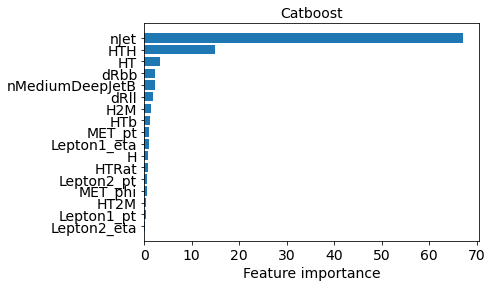

In [71]:
plot_feature_importances(models_cpu["catboost"].get_feature_importance(), TRAIN_FEATURES, title="Catboost")

/tmp/nmangane/ipykernel_3411/2763308995.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  yy = np.arange(len(f_imps)).astype(np.int)


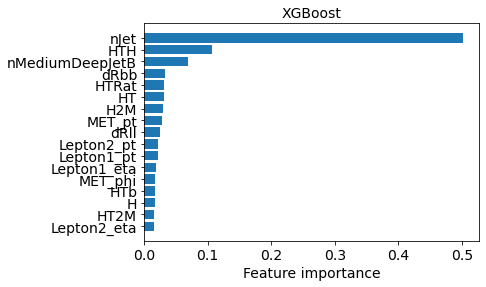

In [72]:
plot_feature_importances(models_cpu["xgboost"].feature_importances_, TRAIN_FEATURES, title="XGBoost")

In [73]:
preferred = "catboost"
print(mode, preferred)
if mode == "vLF":
    model_vLF = models_cpu[preferred]
    print(roc_auc_score(y_test, model_vLF.predict_proba(X_test)[:, 1], sample_weight=w_test))
if mode == "vHF":
    model_vHF = models_cpu[preferred]
    print(roc_auc_score(y_test, model_vHF.predict_proba(X_test)[:, 1], sample_weight=w_test))
if mode == "nested_layer1":
    model_nested_layer1 = models_cpu[preferred]
    print(roc_auc_score(y_test, model_nested_layer1.predict_proba(X_test)[:, 1], sample_weight=w_test))
if mode == "nested_layer2":
    model_nested_layer2 = models_cpu[preferred]
    print(roc_auc_score(y_test, model_nested_layer2.predict_proba(X_test)[:, 1], sample_weight=w_test))
print(model_vLF, model_vHF,  model_nested_layer1,  model_nested_layer2)

if preferred == "catboost":
    models_cpu[preferred].save_model(f"{preferred}_{mode}",
                                     format="cbm",
                                     export_parameters=None,
                                     pool=None
                                    )
if preferred == "xgboost":
    models_cpu[preferred].save_model(f"{preferred}_{mode}.json")
with open(f"{preferred}_{mode}.inputs", "w") as fi:
    for variable in TRAIN_FEATURES:
        fi.write(variable)

vHF catboost
0.7822713798348918
<catboost.core.CatBoostClassifier object at 0x7fb71a14df40> <catboost.core.CatBoostClassifier object at 0x7fb7146c40a0> None None


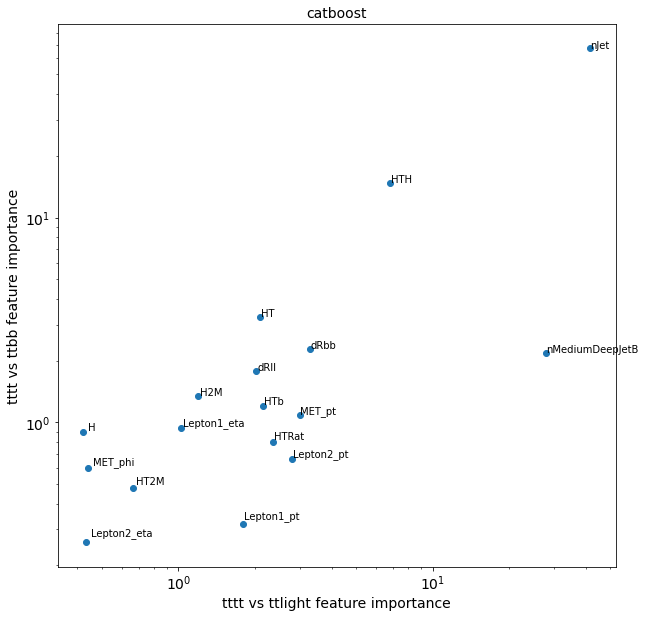

In [83]:
if model_vLF and model_vHF:
    if hasattr(model_vLF, "feature_importances_"):
        fi1 = model_vLF.feature_importances_
    elif hasattr(model_vLF, "get_feature_importance"):
        fi1 = model_vLF.get_feature_importance()
        
    if hasattr(model_vHF, "feature_importances_"):
        fi2 = model_vHF.feature_importances_
    elif hasattr(model_vHF, "get_feature_importance"):
        fi2 = model_vHF.get_feature_importance()
        
    plot_feature_importances_2d(fi1, TRAIN_FEATURES, 
                                fi2, TRAIN_FEATURES,
                                "tttt vs ttlight feature importance", 
                                "tttt vs ttbb feature importance",
                                title=preferred)

In [ ]:
#OLDER STUFF#

In [160]:
print("CATBOOST AUC")
print(roc_auc_score(y_test, clf_cb.predict_proba(X_test)[:, 1], sample_weight=w_test))
print("XGB AUC")
print(roc_auc_score(y_test, clf_xgb.predict_proba(X_test)[:, 1], sample_weight=w_test))

CATBOOST AUC
0.8539057567732808
XGB AUC
0.6133516187703523


/tmp/nmangane/ipykernel_25064/2498021274.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  yy = np.arange(len(f_imps)).astype(np.int)


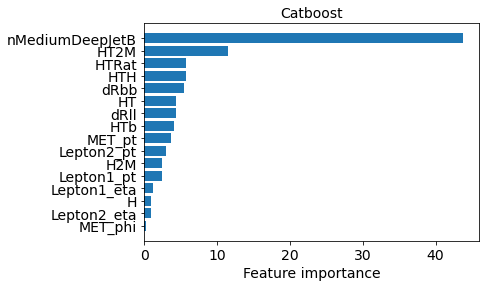

In [161]:
cb_fi = clf_cb.get_feature_importance()
plot_feature_importances(cb_fi, TRAIN_FEATURES, title="Catboost")
#for feat, imp in sorted(zip(TRAIN_FEATURES, cb_fi), key=lambda tup: tup[1], reverse=True):
#    print(f"{feat:20s} \t {imp}")

/tmp/nmangane/ipykernel_25064/2498021274.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  yy = np.arange(len(f_imps)).astype(np.int)


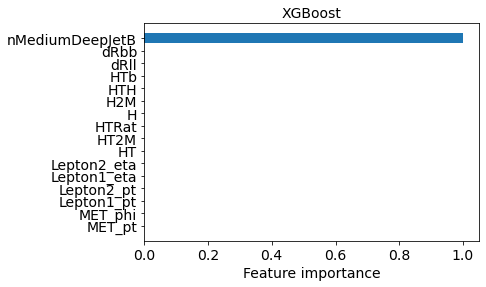

In [162]:
xgb_fi = clf_xgb.feature_importances_
plot_feature_importances(xgb_fi, TRAIN_FEATURES, title="XGBoost")
#for feat, imp in sorted(zip(TRAIN_FEATURES, xgb_fi), key=lambda tup: tup[1], reverse=True):
#    print(f"{feat:20s} \t {imp}")

In [163]:
#for field in events.fields:
#    print(f"{field:35s}\t\t{(np.mean(ak.num(field, axis=0)))}\t{(np.var(ak.num(field, axis=0)))}")

<Array [4, 12, 7, 6, 8, 10, ... 5, 2, 6, 8, 7] type='10000 * int64'>

In [33]:
all_fields = events.fields
print(len(all_fields))
wgts = [all_fields.pop(all_fields.index(f)) for f in all_fields if f.startswith("wgt_")]

print(len(wgts))
print(len(all_fields))

263
34
229
['wgt___nom', 'wgt___OSDL_2018_jesTotalDown', 'wgt___OSDL_2018_HEMDown', 'wgt___OSDL_2018_pileupDown', 'wgt___OSDL_2018_jerDown', 'wgt___OSDL_RunII_btagSF_shape_hfDown', 'wgt___OSDL_2018_btagSF_shape_hfstats1Down', 'wgt___OSDL_2018_btagSF_shape_hfstats2Down', 'wgt___OSDL_RunII_btagSF_shape_cferr1Down', 'wgt___OSDL_RunII_btagSF_shape_cferr2Down', 'wgt___OSDL_RunII_btagSF_shape_lfDown', 'wgt___OSDL_2018_btagSF_shape_lfstats1Down', 'wgt___OSDL_2018_btagSF_shape_lfstats2Down', 'wgt___OSDL_RunII_ISRUp', 'wgt___OSDL_RunII_FSRUp', 'wgt___OSDL_RunII_muFNomRUp', 'wgt___OSDL_RunII_muRNomFUp', 'wgt___OSDL_RunII_muRFcorrelatedDown', 'wgt___OSDL_RunII_pdf2', 'wgt___OSDL_RunII_pdf4', 'wgt___OSDL_RunII_pdf6', 'wgt___OSDL_RunII_pdf8', 'wgt___OSDL_RunII_pdf10', 'wgt___OSDL_RunII_pdf12', 'wgt___OSDL_RunII_pdf14', 'wgt___OSDL_RunII_pdf16', 'wgt___OSDL_RunII_pdf18', 'wgt___OSDL_RunII_pdf20', 'wgt___OSDL_RunII_pdf22', 'wgt___OSDL_RunII_pdf24', 'wgt___OSDL_RunII_pdf26', 'wgt___OSDL_RunII_pdf28', 